In [1]:
import random, os, torch, numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
#seed_everything()

In [2]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import defaultdict
import pandas as pd
#import numpy as np
import torchvision
import torch.fft
import subprocess
import logging
import matplotlib.pyplot as plt
#import random
import shutil
import psutil
import sklearn
import scipy
#import torch
import copy
import yaml
import time
import joblib
import tqdm
import sys
import gc

import torch.optim as optim
from piqa import SSIM

import segmentation_models_pytorch as smp

from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
#import torch

from holodecml.data import PickleReader, UpsamplingReader, XarrayReader#, XarrayReaderLabels
from holodecml.propagation import InferencePropagator
from holodecml.transforms import LoadTransformations
from holodecml.models import load_model
from holodecml.losses import load_loss

#import os
import warnings
warnings.filterwarnings("ignore")
import lpips
import scipy
from matplotlib.patches import Rectangle

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

available_ncpus = len(psutil.Process().cpu_affinity())

# Set up the GPU
is_cuda = torch.cuda.is_available()
device = torch.device("cpu") if not is_cuda else torch.device("cuda")

In [4]:
print(device, available_ncpus)

cuda 8


In [5]:
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [6]:
config = "../config/model_segmentation.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [7]:
# Set seeds for reproducibility
seed = 1000 if "seed" not in conf else conf["seed"]
seed_everything(seed)

save_loc = conf["save_loc"]
os.makedirs(save_loc, exist_ok = True)
os.makedirs(os.path.join(save_loc, "images"), exist_ok = True)
if not os.path.isfile(os.path.join(save_loc, "model.yml")):
    shutil.copyfile(config, os.path.join(save_loc, "model.yml"))

tile_size = int(conf["data"]["tile_size"])
step_size = int(conf["data"]["step_size"])
data_path = conf["style"]["synthetic"]["save_path"]

total_positive = int(conf["data"]["total_positive"])
total_negative = int(conf["data"]["total_negative"])
total_examples = int(conf["data"]["total_training"])

transform_mode = "None" if "transform_mode" not in conf["data"] else conf["data"]["transform_mode"]
config_ncpus = int(conf["data"]["cores"])
use_cached = False if "use_cached" not in conf["data"] else conf["data"]["use_cached"]

name_tag = f"{tile_size}_{step_size}_{total_positive}_{total_negative}_{total_examples}_{transform_mode}"
fn_train = f"{data_path}/train_{name_tag}.nc"
fn_valid = f"{data_path}/valid_{name_tag}.nc"

style_data_path = conf["style"]["raw"]["save_path"]
sampler = conf["style"]["raw"]["sampler"]
fn_train_raw = os.path.join(style_data_path, f"train_{sampler}_{name_tag}.nc")
fn_valid_raw = os.path.join(style_data_path, f"valid_{sampler}_{name_tag}.nc")
fn_test_raw = os.path.join(style_data_path, f"test_{sampler}_{name_tag}.nc")

#fn_train_raw = os.path.join(style_data_path, f"training_{name_tag}.nc")
#fn_valid_raw = os.path.join(style_data_path, f"validation_{name_tag}.nc")
#fn_test_raw = os.path.join(style_data_path, f"test_{name_tag}.nc")

# Trainer params
train_batch_size = conf["trainer"]["train_batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]

epochs = conf["trainer"]["epochs"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]

In [8]:
# Load the preprocessing transforms
train_transforms = None 
valid_transforms = None 

In [9]:
train_synthetic_dataset = XarrayReader(fn_train, train_transforms)

In [10]:
train_synthetic_loader = torch.utils.data.DataLoader(
    train_synthetic_dataset,
    batch_size=train_batch_size,
    num_workers=available_ncpus,
    pin_memory=True,
    shuffle=True)

In [11]:
train_holodec_dataset = XarrayReader(fn_train_raw, train_transforms)

In [12]:
train_holodec_loader = torch.utils.data.DataLoader(
    train_holodec_dataset,
    batch_size=train_batch_size,
    num_workers=available_ncpus,
    pin_memory=True,
    shuffle=True)

# Neural style transfer - https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

### Load losses

In [13]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [14]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [15]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [16]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())


In [17]:
def rename_vgg_layers(model):
    """Renames VGG model layers to match those in the paper."""
    block, number = 1, 1
    renamed = nn.Sequential()
    for i,layer in enumerate(model.children()):
        if i == 0:
            layer = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            name = f'conv{block}_{number}'
        elif isinstance(layer, nn.Conv2d):
            name = f'conv{block}_{number}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu{block}_{number}'
            # The inplace ReLU version doesn't play nicely with NST.
            layer = nn.ReLU(inplace=False)
            number += 1
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{block}'
            # Average pooling was found to generate images of higher quality than
            # max pooling by Gatys et al.
            layer = nn.AvgPool2d(layer.kernel_size, layer.stride)
            block += 1
            number = 1
        else:
            raise RuntimeError(f'Unrecognized layer "{layer.__class__.__name__}""') 
        renamed.add_module(name, layer)
    return renamed

In [18]:
cnn = torchvision.models.vgg19(pretrained=True).features
cnn = rename_vgg_layers(cnn).to(device).eval()

In [19]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [20]:
def get_style_model_and_losses(cnn, 
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(*[])

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.AvgPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [21]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img], lr = 1)
    #optimizer = optim.Adam([input_img], lr = 1)
    return optimizer

In [105]:
def run_style_transfer(cnn, 
                       content_img,
                       style_img,
                       input_img, 
                       num_steps=300,
                       style_weight=1000000, 
                       content_weight=1, 
                       get_losses=0,
                       verbose=0):
    
    """Run the style transfer."""
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)
    
    if get_losses:
        losses = defaultdict(list)
        
    save_every = [10, 50, 100, 200, 500]
    losses["images"].append(255. * input_img.squeeze(0).squeeze(0).detach().cpu().numpy())

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses: # add weights
                style_score += sl.loss
            for cl in content_losses: # add weights 
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight
            tvloss = tv_loss(input_img)

            loss = style_score + content_score + tvloss
            loss.backward()

            run[0] += 1
            if run[0] % 1 == 0 and verbose:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                
            if get_losses:
                losses["epoch"].append(run[0]-1)
                losses["style"].append(style_score.item())
                losses["tv"].append(tvloss.item())
                losses["content"].append(content_score.item())
                losses["total"].append(style_score.item()+content_score.item() + tvloss.item())
                
                if  run[0] in save_every:
                    losses["images"].append(255. * input_img.squeeze(0).squeeze(0).detach().cpu().numpy())

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)
        
    if get_losses:
        return input_img, losses

    return input_img

In [32]:
# class SSIMLoss(SSIM):
#     def forward(self, x, y):
#         try:
#             return super().forward(x, y).item()
#         except:
#             return -10

In [33]:
perceptual_alex = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /glade/work/schreck/py37/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


### Train on single image

In [49]:
weights = np.logspace(-5, 15, num=20, endpoint=True)

In [106]:
x_s, y_s = train_synthetic_dataset.__getitem__(0) # 0 

In [107]:
x_h, y_h = train_holodec_dataset.__getitem__(108) # 108

In [108]:
content_img = x_s.clone().unsqueeze(0).to(device).float() / 255.0
style_img = x_h.clone().unsqueeze(0).to(device).float() / 255.0
input_img = torch.randn_like(x_h.clone()).unsqueeze(0).to(device).float()

In [109]:
#%%timeit 
output, losses = run_style_transfer(cnn, 
                            content_img, 
                            style_img, 
                            input_img, 
                            style_weight = 5.45559478e+09,
                            content_weight = 1.,
                            verbose = 0,
                            get_losses = 1,
                            num_steps = 500)

In [110]:
syn_score = perceptual_alex(content_img, output).mean().item()
holo_score = perceptual_alex(style_img, output).mean().item()
mixed_score = perceptual_alex(content_img, style_img).mean().item()
print(syn_score, holo_score, mixed_score)

0.4981614947319031 0.1017974466085434 0.5196780562400818


In [111]:
#ssim(content_img, output).item()

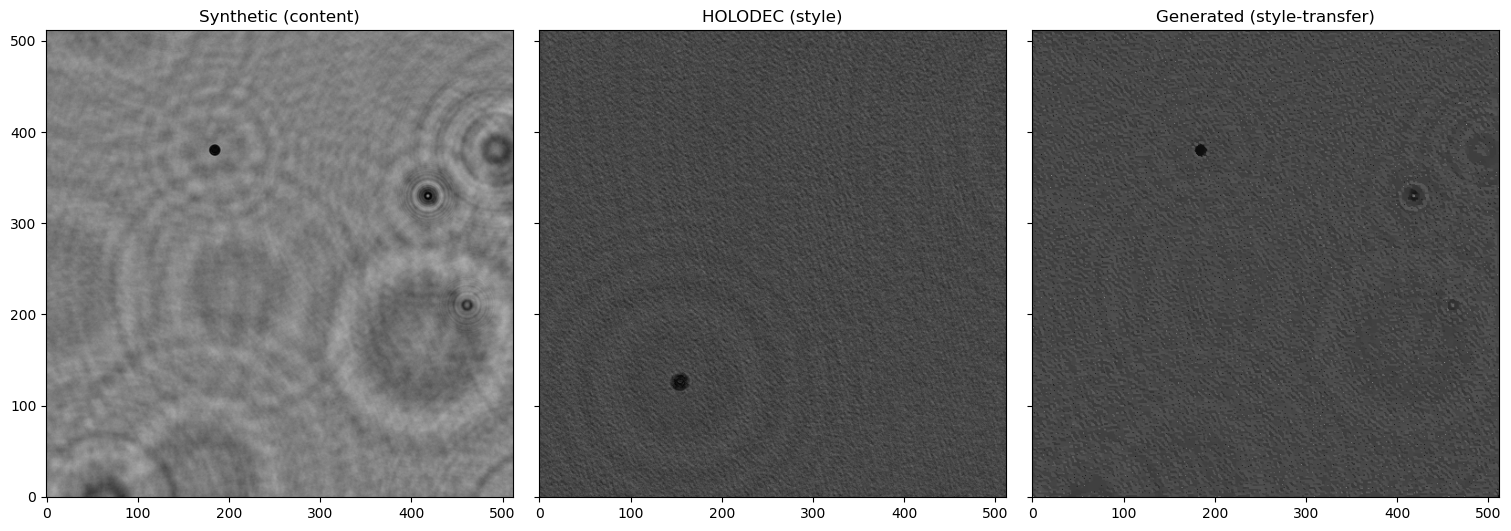

In [112]:
(ax1, ax2, ax3) = plt.figure(constrained_layout=True, figsize = (15, 10)).subplots(1, 3, sharex=True, sharey=True)

ax1.imshow(content_img[0][0].detach().cpu().numpy(), vmin=0, vmax=1, cmap = "gray", origin="lower")
ax2.imshow(style_img[0][0].detach().cpu().numpy(), vmin=0, vmax=1, cmap = "gray", origin="lower")
ax3.imshow(output[0][0].detach().cpu().numpy(), vmin=0, vmax=1, cmap = "gray", origin="lower")


ax1.set_title("Synthetic (content)")
ax2.set_title("HOLODEC (style)")
ax3.set_title("Generated (style-transfer)")
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

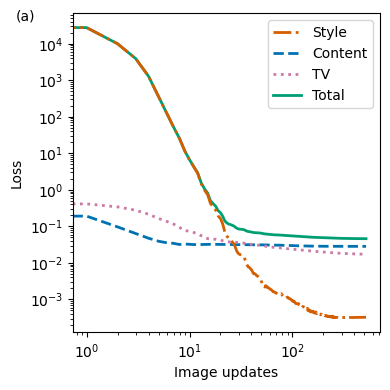

In [156]:
fontsize = 10
single_column_width = 4

figsize = (single_column_width, 4)
fig, ax1 = plt.subplots(1, 1, figsize=figsize)
                       #gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

ax1.plot(losses["epoch"], losses["style"], ls = "-.", c = "#d55e00", lw = 2, zorder = 2)
ax1.plot(losses["epoch"], losses["content"], ls = "--", c = "#0072b2", lw = 2, zorder = 1)
ax1.plot(losses["epoch"], losses["tv"], ls = ":", c = "#cc79a7", lw = 2, zorder = 1)
ax1.plot(losses["epoch"], losses["total"], ls = "-", c = "#009e73", lw = 2, zorder = 1)

ax1.set_yscale("log")
ax1.set_xscale("log")

ax1.set_ylabel("Loss", fontsize=fontsize)
ax1.set_xlabel("Image updates", fontsize=fontsize)
ax1.legend(["Style", "Content", "TV", "Total"], fontsize=fontsize, loc = "best")
ax1.text(-0.122, 1.01, "(a)", transform=ax1.transAxes, fontsize=fontsize, va='top', ha='right')

plt.tight_layout()
plt.savefig("../paper_figures/loss_example.png", dpi = 300, bbox_inches='tight')
plt.show()

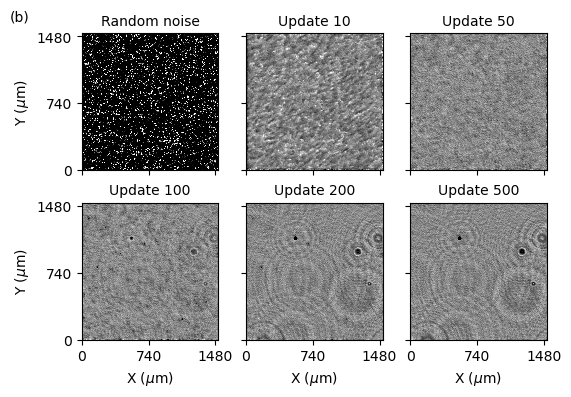

In [158]:
figsize = (6, 4)
fig, axes = plt.subplots(2, 3, figsize=figsize, sharex = True, sharey = True, gridspec_kw={'hspace': 0.225, 'wspace': 0.2})
cmap = "gray"
vmin, vmax = 50, 90
scale_x = 2.96e-06 
scale_y = 2.96e-06
scale_z = 1.00e-06

axes[0, 0].imshow(losses["images"][0], vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
axes[0, 1].imshow(losses["images"][1], vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
axes[0, 2].imshow(losses["images"][2], vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
axes[1, 0].imshow(losses["images"][3], vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
axes[1, 1].imshow(losses["images"][4], vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
axes[1, 2].imshow(losses["images"][5], vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")

ticks = [0, 250, 500]
for k in range(2):
    axes[k][0].set_yticks(ticks)
    axes[k][0].set_yticklabels([int(round(x * scale_y / 1e-6, 2)) for x in ticks], fontsize = fontsize)
    axes[k][0].set_ylabel(r"Y ($\mu$m)", fontsize=fontsize)

for k in range(3):
    axes[1][k].set_xticks(ticks)
    axes[1][k].set_xticklabels([int(round(x * scale_x / 1e-6, 2)) for x in ticks], fontsize = fontsize)
    axes[1][k].set_xlabel(r"X ($\mu$m)", fontsize=fontsize)
    
axes[0, 0].set_title("Random noise", fontsize = fontsize)
axes[0, 1].set_title("Update 10", fontsize = fontsize)
axes[0, 2].set_title("Update 50", fontsize = fontsize)
axes[1, 0].set_title("Update 100", fontsize = fontsize)
axes[1, 1].set_title("Update 200", fontsize = fontsize)
axes[1, 2].set_title("Update 500", fontsize = fontsize)

axes[0, 0].text(-0.38, 1.175, "(b)", transform=axes[0, 0].transAxes, fontsize=fontsize, va='top', ha='right')

plt.tight_layout()
plt.savefig("../paper_figures/loss_example_images.png", dpi = 300, bbox_inches='tight')
plt.show()

### Compute perception scores between syn and holo

In [35]:
# synthetic_examples = []
# holodec_examples = []

# for n in range(100):
#     sn = random.randint(0, train_synthetic_dataset.__len__())
#     x_s, y_s = train_synthetic_dataset.__getitem__(sn)
#     hn = random.randint(0, train_holodec_dataset.__len__())
#     x_h, y_h = train_holodec_dataset.__getitem__(hn)
#     synthetic_examples.append(x_s.unsqueeze(0).float() / 255.0)
#     holodec_examples.append(x_h.unsqueeze(0).float() / 255.0)

##### Perceptual similarity

In [36]:
# similarities = {}

In [37]:
# syn_holo_score = [
#     perceptual_alex(x_s.to(device), x_h.to(device)).mean().item() 
#     for x_h in holodec_examples 
#     for x_s in synthetic_examples
# ]

In [38]:
# syn_syn_score = [
#     perceptual_alex(x_s.to(device), x_h.to(device)).mean().item() 
#     for i, x_h in enumerate(synthetic_examples) 
#     for j, x_s in enumerate(synthetic_examples) if i != j
# ]

In [39]:
# holo_holo_score = [
#     perceptual_alex(x_s.to(device), x_h.to(device)).mean().item() 
#     for i, x_h in enumerate(holodec_examples) 
#     for j, x_s in enumerate(holodec_examples) if i != j
# ]

In [40]:
# print(np.mean(syn_holo_score), np.mean(syn_syn_score), np.mean(holo_holo_score))

In [41]:
# print(np.std(syn_holo_score), np.std(syn_syn_score), np.std(holo_holo_score))

### Compute perception scores between 

In [42]:
# totals = {}

# num_examples = 5
# num_weights = 5
# weights = np.logspace(-5, 15, num=num_weights, endpoint=True)

# for p, w in tqdm.tqdm(enumerate(weights), total = num_weights):
    
#     results_dict = defaultdict(list)
    
#     for n in range(num_examples):
#         x_s = random.choice(synthetic_examples)
#         x_h = random.choice(holodec_examples)

#         try:
#             content_img = x_s.clone().to(device).float() 
#             style_img = x_h.clone().to(device).float() 
#             input_img = torch.randn_like(style_img.clone()).to(device).float()
#             output = run_style_transfer(cnn, 
#                                     content_img, 
#                                     style_img, 
#                                     input_img,
#                                     style_weight = w,
#                                     content_weight = 1,
#                                     verbose = 0,
#                                     num_steps = 200)
#             holo_score = perceptual_alex(style_img, output).mean().item()
#             syn_score = perceptual_alex(content_img, output).mean().item()
#             mixed_score = perceptual_alex(content_img, style_img).mean().item()
#             results_dict["holo_style_alex"].append(holo_score)
#             results_dict["syn_style_alex"].append(syn_score)
#             results_dict["holo_syn_alex"].append(mixed_score)
#             holo_score = ssim(style_img, output).item()
#             syn_score = ssim(content_img, output).item()
#             mixed_score = ssim(content_img, style_img).item()
#             results_dict["holo_style_ssim"].append(holo_score)
#             results_dict["syn_style_ssim"].append(syn_score)
#             results_dict["holo_syn_ssim"].append(mixed_score)
#         except:
#             continue
        
#     totals[p] = (w, results_dict)

In [43]:
# import joblib
# with open("../paper_figures/data/style_and_similarity.pkl", "wb") as fid:
#     joblib.dump(totals, fid)

In [44]:
# fontsize = 10
# single_column_width = 10
# dim = 512 ** 2

# figsize = (single_column_width, 3)
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
#                        figsize=figsize, )
#                        #gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# ax1.plot(losses["epoch"], losses["style"], ls = "-.", c = "#d55e00")
# ax1.plot(losses["epoch"], losses["content"], ls = "--", c = "#0072b2")
# ax1.plot(losses["epoch"], losses["total"], ls = "-", c = "#009e73")

# ax2.errorbar(weights/dim, 
#              [np.mean(r[1]["holo_style_ssim"]) for r in totals.values()],
#              [np.std(r[1]["holo_style_ssim"]) for r in totals.values()], ls = "-.", c = "#d55e00"
#             )
# ax2.errorbar(weights/dim, 
#              [np.mean(r[1]["syn_style_ssim"]) for r in totals.values()],
#              [np.std(r[1]["syn_style_ssim"]) for r in totals.values()], ls = "--", c = "#0072b2"
#             )
# ax2.errorbar(weights/dim, 
#              [np.mean(r[1]["holo_syn_ssim"]) for r in totals.values()],
#              [np.std(r[1]["holo_syn_ssim"]) for r in totals.values()], ls = "-", c = "#009e73"
#             )

# ax3.errorbar(weights/dim, 
#              [1-np.mean(r[1]["holo_style_alex"]) for r in totals.values()],
#              [np.std(r[1]["holo_style_alex"]) for r in totals.values()], ls = "-.", c = "#d55e00"
#             )
# ax3.errorbar(weights/dim, 
#              [1-np.mean(r[1]["syn_style_alex"]) for r in totals.values()],
#              [np.std(r[1]["syn_style_alex"]) for r in totals.values()], ls = "--", c = "#0072b2"
#             )
# ax3.errorbar(weights/dim, 
#              [1-np.mean(r[1]["holo_syn_alex"]) for r in totals.values()],
#              [np.std(r[1]["holo_syn_alex"]) for r in totals.values()], ls = "-", c = "#009e73"
#             )

# ax1.set_yscale("log")
# ax1.set_xscale("log")
# ax2.set_xscale("log")
# ax3.set_xscale("log")

# ax1.set_ylabel("Loss", fontsize=fontsize)
# ax2.set_ylabel("SSIM", fontsize=fontsize)
# ax3.set_ylabel("Similarity (AlexNet)", fontsize=fontsize)

# ax1.set_xlabel("Image weight updates", fontsize=fontsize)
# ax2.set_xlabel(r"w$_s$ / (L$^2$ w$_c$) ", fontsize=fontsize)
# ax3.set_xlabel(r"w$_s$ / (L$^2$ w$_c$) ", fontsize=fontsize)

# ax1.legend(["Style", "Content", "Total"], fontsize=fontsize, loc = "best")
# ax2.legend(["H-Sty", "Syn-Sty", "H-Syn"], fontsize=fontsize, loc = "best")
# ax3.legend(["H-Sty", "Syn-Sty", "H-Syn"], fontsize=fontsize, loc = "best")

# plt.tight_layout()
# #plt.savefig("../paper_figures/style_and_similarity.pdf", dpi = 300, bbox_inches='tight')
# plt.show()

### Show some examples

In [110]:
arr, n = scipy.ndimage.label(y_s)
_centroid = scipy.ndimage.find_objects(arr)
for particle in _centroid:
    xind = (particle[0].stop + particle[0].start) // 2
    yind = (particle[1].stop + particle[1].start) // 2
    dind = max([
        abs(particle[0].stop - particle[0].start), 
        abs(particle[1].stop - particle[1].start)
    ])
    print(xind, yind, dind)

380 185 12


0.5651566982269287 0.12854456901550293 0.5196780562400818
0.5651566982269287 0.2299160659313202 0.5327122807502747
0.5651566982269287 0.11763705313205719 0.5756987929344177


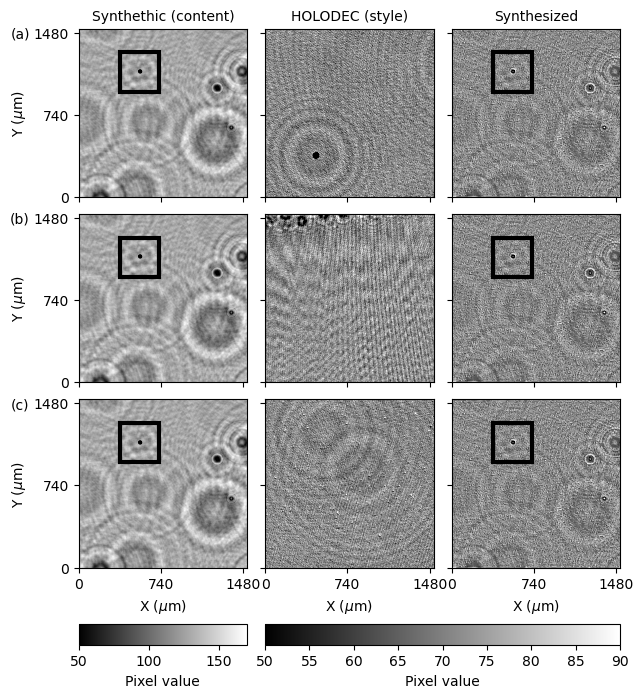

In [248]:
scale_x = 2.96e-06 
scale_y = 2.96e-06
scale_z = 1.00e-06

fontsize = 10
single_column_width = 7
vmin = 50
vmax = 90
cmap = "gray"
#matplotlib.rc('xtick', labelsize=fontsize) 
#matplotlib.rc('ytick', labelsize=fontsize)

figsize = (7, 7)
fig, ax = plt.subplots(3, 3,
                       figsize=figsize, 
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, 
                       #constrained_layout=True,
                       sharex=True, sharey=True)

x_s, y_s = train_synthetic_dataset.__getitem__(0)

for i, k in enumerate([108, 334, 139]): # [123, 46, 82, 1024] # 200
    x_h, y_h = train_holodec_dataset.__getitem__(k)
    content_img = x_s.clone().unsqueeze(0).to(device).float() / 255.0
    style_img = x_h.clone().unsqueeze(0).to(device).float() / 255.0
    input_img = torch.randn_like(x_s.clone()).unsqueeze(0).to(device).float() / 255.0
 
#     #output = run_style_transfer(cnn, 
#                                 content_img, 
#                                 style_img, 
#                                 input_img, 
#                                 style_weight = 5.45559478e+09,
#                                 content_weight = 1,
#                                 verbose = 0,
#                                 num_steps = 500)
    
    ax1, ax2, ax3 = ax[i]

    imm1=ax1.imshow(255 * content_img[0][0].detach().cpu().numpy(), 
               vmin=50, vmax=170, cmap = cmap, origin="lower")
    imm2=ax2.imshow(255 * style_img[0][0].detach().cpu().numpy(), 
            vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
    imm3=ax3.imshow(255 * output[0][0].detach().cpu().numpy(), 
              vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
    
    ax1.add_patch(
        Rectangle((yind - 5 * dind, xind - 5 * dind), 10 * dind, 10 * dind,
                  edgecolor = 'k',
                  facecolor = None,
                  fill=False,
                  zorder=3,
                  lw=3))
    ax3.add_patch(
        Rectangle((yind - 5 * dind, xind - 5 * dind), 10 * dind, 10 * dind,
                  edgecolor = 'k',
                  facecolor = None,
                  fill=False,
                  zorder=3,
                  lw=3))
    
    syn_score = perceptual_alex(content_img, output).mean().item()
    holo_score = perceptual_alex(style_img, output).mean().item()
    mixed_score = perceptual_alex(content_img, style_img).mean().item()
    
    print(syn_score, holo_score, mixed_score)

    if i == 0:
        ax1.set_title("Synthethic (content)", fontsize = fontsize)
        ax2.set_title("HOLODEC (style)", fontsize = fontsize)
        ax3.set_title("Synthesized", fontsize = fontsize)
        
        
ticks = [0, 250, 500]
for k in range(3):
    ax[k][0].set_yticks(ticks)
    ax[k][0].set_yticklabels([int(round(x * scale_y / 1e-6, 2)) for x in ticks], fontsize = fontsize)
    ax[k][0].set_ylabel(r"Y ($\mu$m)", fontsize=fontsize)

for k in range(3):
    ax[-1][k].set_xticks(ticks)
    ax[-1][k].set_xticklabels([int(round(x * scale_x / 1e-6, 2)) for x in ticks], fontsize = fontsize)
    ax[-1][k].set_xlabel(r"X ($\mu$m)", fontsize=fontsize)
        
        
p0 = ax[-1][0].get_position().get_points().flatten()
p1 = ax[-1][1].get_position().get_points().flatten()
cbar_ax = fig.add_axes([p0[0], p0[1] - 0.11, p0[2]-p0[0], 0.03])
cbar = plt.colorbar(imm1, cax=cbar_ax, orientation = "horizontal")
cbar.set_label('Pixel value', fontsize=fontsize)

p0 = ax[-1][1].get_position().get_points().flatten()
p1 = ax[-1][2].get_position().get_points().flatten()
cbar_ax = fig.add_axes([p0[0], p0[1] - 0.11, p1[2]-p0[0], 0.03])
cbar = plt.colorbar(imm2, cax=cbar_ax, orientation = "horizontal")
cbar.set_label('Pixel value', fontsize=fontsize)

ax[0][0].text(-0.29, 1.01, "(a)", transform=ax[0][0].transAxes, fontsize=fontsize, va='top', ha='right')
ax[1][0].text(-0.29, 1.01, "(b)", transform=ax[1][0].transAxes, fontsize=fontsize, va='top', ha='right')
ax[2][0].text(-0.29, 1.01, "(c)", transform=ax[2][0].transAxes, fontsize=fontsize, va='top', ha='right')

plt.tight_layout()  
plt.savefig("../paper_figures/hologram_style_example.pdf", dpi = 300, bbox_inches='tight')
plt.show()

0.5020745396614075 0.10177047550678253 0.5196780562400818
0.5035549402236938 0.18632479012012482 0.5327122807502747
0.5651566982269287 0.11763705313205719 0.5756987929344177


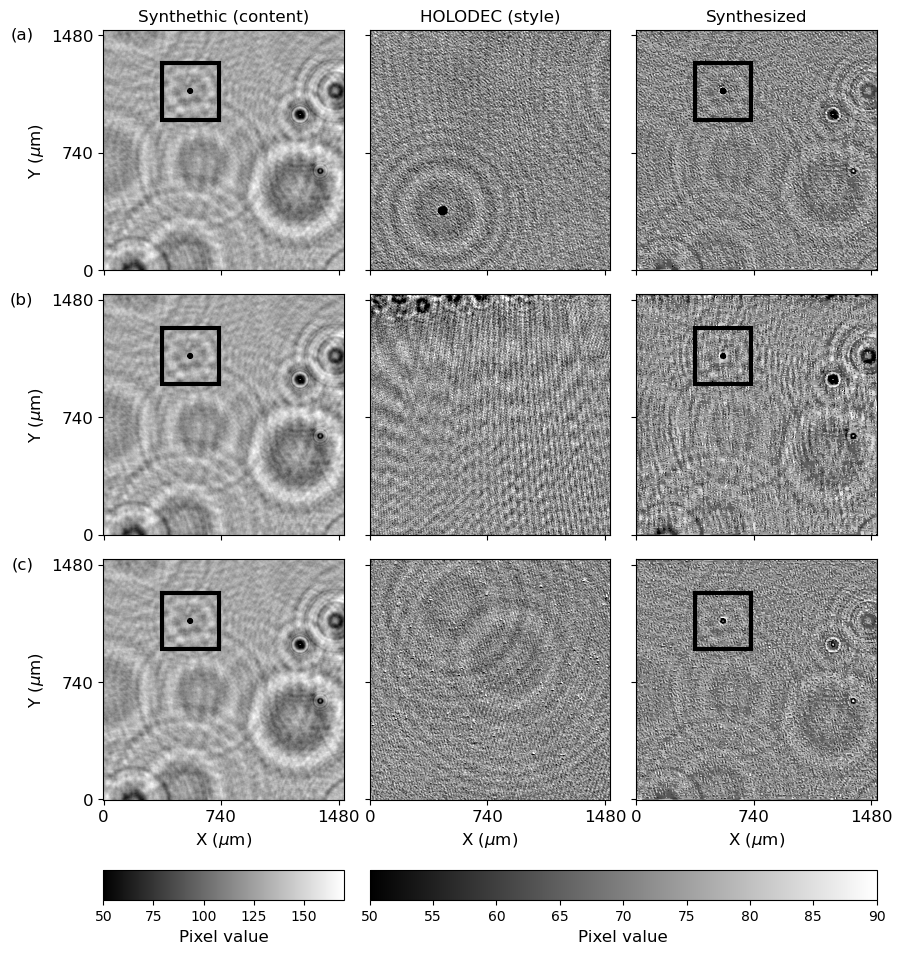

In [243]:
scale_x = 2.96e-06 
scale_y = 2.96e-06
scale_z = 1.00e-06

fontsize = 12
single_column_width = 10
vmin = 50
vmax = 90
cmap = "gray"
#matplotlib.rc('xtick', labelsize=fontsize) 
#matplotlib.rc('ytick', labelsize=fontsize)

figsize = (single_column_width, single_column_width)
fig, ax = plt.subplots(3, 3,
                       figsize=figsize, 
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, 
                       #constrained_layout=True,
                       sharex=True, sharey=True)

x_s, y_s = train_synthetic_dataset.__getitem__(0)

for i, k in enumerate([108, 334, 139]): # [123, 46, 82, 1024] # 200
    x_h, y_h = train_holodec_dataset.__getitem__(k)
    content_img = x_s.clone().unsqueeze(0).to(device).float() / 255.0
    style_img = x_h.clone().unsqueeze(0).to(device).float() / 255.0
    input_img = torch.randn_like(x_s.clone()).unsqueeze(0).to(device).float() / 255.0
 
    output = run_style_transfer(cnn, 
                                content_img, 
                                style_img, 
                                input_img, 
                                style_weight = 5.45559478e+09,
                                content_weight = 1,
                                verbose = 0,
                                num_steps = 500)
    
    ax1, ax2, ax3 = ax[i]

    imm1=ax1.imshow(255 * content_img[0][0].detach().cpu().numpy(), 
               vmin=50, vmax=170, cmap = cmap, origin="lower")
    imm2=ax2.imshow(255 * style_img[0][0].detach().cpu().numpy(), 
            vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
    imm3=ax3.imshow(255 * output[0][0].detach().cpu().numpy(), 
              vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
    
    ax1.add_patch(
        Rectangle((yind - 5 * dind, xind - 5 * dind), 10 * dind, 10 * dind,
                  edgecolor = 'k',
                  facecolor = None,
                  fill=False,
                  zorder=3,
                  lw=3))
    ax3.add_patch(
        Rectangle((yind - 5 * dind, xind - 5 * dind), 10 * dind, 10 * dind,
                  edgecolor = 'k',
                  facecolor = None,
                  fill=False,
                  zorder=3,
                  lw=3))
    
    syn_score = perceptual_alex(content_img, output).mean().item()
    holo_score = perceptual_alex(style_img, output).mean().item()
    mixed_score = perceptual_alex(content_img, style_img).mean().item()
    
    print(syn_score, holo_score, mixed_score)

    if i == 0:
        ax1.set_title("Synthethic (content)", fontsize = fontsize)
        ax2.set_title("HOLODEC (style)", fontsize = fontsize)
        ax3.set_title("Synthesized", fontsize = fontsize)
        
        
ticks = [0, 250, 500]
for k in range(3):
    ax[k][0].set_yticks(ticks)
    ax[k][0].set_yticklabels([int(round(x * scale_y / 1e-6, 2)) for x in ticks], fontsize = fontsize)
    ax[k][0].set_ylabel(r"Y ($\mu$m)", fontsize=fontsize)

for k in range(3):
    ax[-1][k].set_xticks(ticks)
    ax[-1][k].set_xticklabels([int(round(x * scale_x / 1e-6, 2)) for x in ticks], fontsize = fontsize)
    ax[-1][k].set_xlabel(r"X ($\mu$m)", fontsize=fontsize)
        
        
p0 = ax[-1][0].get_position().get_points().flatten()
p1 = ax[-1][1].get_position().get_points().flatten()
cbar_ax = fig.add_axes([p0[0], p0[1] - 0.1, p0[2]-p0[0], 0.03])
cbar = plt.colorbar(imm1, cax=cbar_ax, orientation = "horizontal")
cbar.set_label('Pixel value', fontsize=fontsize)

p0 = ax[-1][1].get_position().get_points().flatten()
p1 = ax[-1][2].get_position().get_points().flatten()
cbar_ax = fig.add_axes([p0[0], p0[1] - 0.1, p1[2]-p0[0], 0.03])
cbar = plt.colorbar(imm2, cax=cbar_ax, orientation = "horizontal")
cbar.set_label('Pixel value', fontsize=fontsize)

ax[0][0].text(-0.29, 1.01, "(a)", transform=ax[0][0].transAxes, fontsize=fontsize, va='top', ha='right')
ax[1][0].text(-0.29, 1.01, "(b)", transform=ax[1][0].transAxes, fontsize=fontsize, va='top', ha='right')
ax[2][0].text(-0.29, 1.01, "(c)", transform=ax[2][0].transAxes, fontsize=fontsize, va='top', ha='right')

plt.tight_layout()  
plt.savefig("../paper_figures/hologram_style_example.pdf", dpi = 300, bbox_inches='tight')
plt.show()

In [123]:
weights = np.logspace(-5, 15, num=20, endpoint=True)
cmap = "gray"

images = []
for k, weight in enumerate(weights):
    attempt = 0
    while attempt < 5:
        x_s, y_s = train_synthetic_dataset.__getitem__(0)
        x_h, y_h = train_holodec_dataset.__getitem__(108)
        content_img = x_s.clone().unsqueeze(0).to(device).float() / 255.0
        style_img = x_h.clone().unsqueeze(0).to(device).float() / 255.0
        input_img = torch.randn_like(x_s.clone()).unsqueeze(0).to(device).float() / 255.0

        output = run_style_transfer(cnn, 
                                    content_img, 
                                    style_img, 
                                    input_img, 
                                    style_weight = weight,
                                    content_weight = 1,
                                    verbose = 0,
                                    num_steps = 500)

        holo_score = perceptual_alex(style_img, output).mean().item()
        print(k, attempt, weight, holo_score)
        if holo_score < 0.0:
            attempt += 1
            continue
        else:
            break
    
    ax = plt.figure(constrained_layout=True, figsize = (7, 5)).subplots(1, 1, sharex=True, sharey=True)
    im=ax.imshow(255 * output[0][0].detach().cpu().numpy(), vmin=50, vmax=170, cmap = cmap, origin="lower")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    plt.savefig(f"../paper_figures/panels/weight_{k}.png", dpi = 300, bbox_inches='tight', transparent = True)
    #plt.show()
    
    images.append(255 * output[0][0].detach().cpu().numpy())
with open("../paper_figures/panels/images.pkl", "wb") as fid:
    joblib.dump(images, fid)

0 0 1e-05 0.4557328224182129
1 0 0.00011288378916846884 0.6841890215873718
2 0 0.0012742749857031334 0.6467149257659912
3 0 0.01438449888287663 0.3912983536720276
4 0 0.1623776739188721 0.4960934817790985
5 0 1.8329807108324339 0.3969399631023407
6 0 20.6913808111479 0.3880038857460022
7 0 233.57214690901213 0.43124282360076904
8 0 2636.6508987303555 0.4017176330089569
9 0 29763.51441631313 0.32096734642982483
10 0 335981.8286283774 0.4751500189304352
11 0 3792690.1907322383 0.36796244978904724
12 0 42813323.98719396 0.17773203551769257
13 0 483293023.85717523 0.1272794008255005
14 0 5455594781.168514 0.10226906836032867
15 0 61584821106.60255 0.09406188875436783
16 0 695192796177.5591 0.09661275148391724
17 0 7847599703514.623 0.0927075520157814
18 0 88586679041007.95 0.09166647493839264
19 0 1000000000000000.0 0.08961250633001328


In [25]:
with open("../paper_figures/panels/images.pkl", "rb") as fid:
    images = joblib.load(fid)

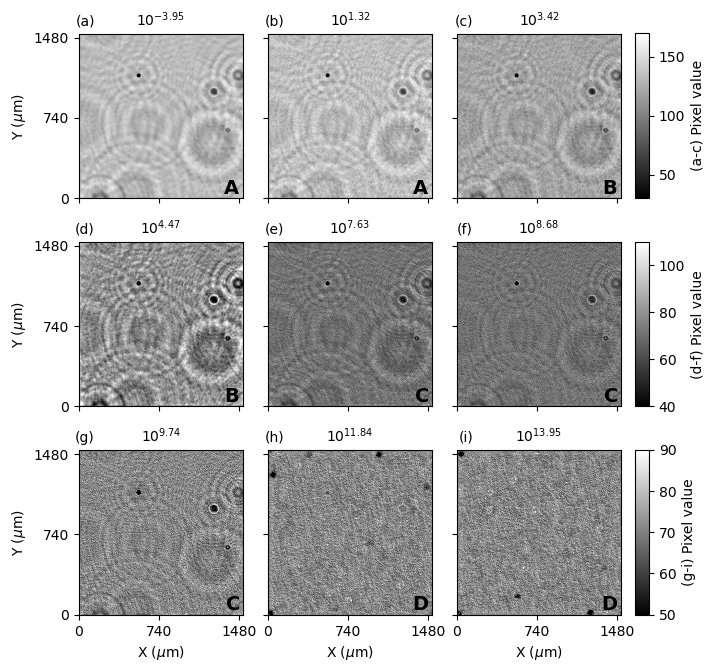

In [236]:
selected = [1, 6, 8, 9, 12, 13, 14, 16, 18]
weights = np.logspace(-5, 15, num=20, endpoint=True)
weights = [weights[k] for k in selected]
ims = [images[k] for k in selected]

ws = np.array_split(weights, 3)
ims = np.array_split(ims, 3)


scale_x = 2.96e-06 
scale_y = 2.96e-06
scale_z = 1.00e-06


vmins = [30, 40, 50]
vmaxs = [170, 110, 90]

figsize=(7, 8.5)
fontsize = 10

fig, ax = plt.subplots(3, 3,
                       figsize=figsize, 
                       gridspec_kw={'hspace': -0.125, 'wspace': 0.15}, 
                       #constrained_layout=True,
                       sharex=True, sharey=True)

cmap = "gray"
imshows = {}
for p, a in enumerate(ax):
    for q, j in enumerate(a):
        im = ax[p][q].imshow(ims[p][q], vmin=vmins[p], vmax=vmaxs[p], cmap = cmap, origin="lower")
        imshows[p,q] = im
        power = '{' + str(np.round(np.log10(ws[p][q]), 2)) + '}'
        ax[p][q].set_title(f"$10^{power}$", fontsize = fontsize)
        ticks = [0, 250, 500]

        if q == 0:
            ax[p][q].set_yticks(ticks)
            ax[p][q].set_yticklabels([int(round(x * scale_y / 1e-6, 2)) for x in ticks])
            ax[p][q].set_ylabel(r"Y ($\mu$m)", fontsize=fontsize)
        
        if p == 2:
            ax[p][q].set_xticks(ticks)
            ax[p][q].set_xticklabels([int(round(x * scale_x / 1e-6, 2)) for x in ticks])
            ax[p][q].set_xlabel(r"X ($\mu$m)", fontsize=fontsize)
            
p1 = ax[0][2].get_position().get_points().flatten()
cbar_ax = fig.add_axes([0.92, p1[1], 0.02, 0.194]) # left, bottom, width, height
cbar = plt.colorbar(imshows[0,0], cax=cbar_ax, orientation = "vertical")
cbar.set_label('(a-c) Pixel value')

p1 = ax[1][2].get_position().get_points().flatten()
cbar_ax = fig.add_axes([0.92, p1[1], 0.02, 0.194]) # left, bottom, width, height
cbar = plt.colorbar(imshows[1,0], cax=cbar_ax, orientation = "vertical")
cbar.set_label('(d-f) Pixel value')

p1 = ax[2][2].get_position().get_points().flatten()
cbar_ax = fig.add_axes([0.92, p1[1], 0.02, 0.194]) # left, bottom, width, height
cbar = plt.colorbar(imshows[2,0], cax=cbar_ax, orientation = "vertical")
cbar.set_label('(g-i) Pixel value')

a, b = 0.98, 0.12
ax[0][0].text(a, b, r"$\mathbf{A}$", transform=ax[0][0].transAxes, fontsize=14, va='top', ha='right')
ax[0][1].text(a, b, r"$\mathbf{A}$", transform=ax[0][1].transAxes, fontsize=14, va='top', ha='right')
ax[0][2].text(a, b, r"$\mathbf{B}$", transform=ax[0][2].transAxes, fontsize=14, va='top', ha='right')
ax[1][0].text(a, b, r"$\mathbf{B}$", transform=ax[1][0].transAxes, fontsize=14, va='top', ha='right')
ax[1][1].text(a, b, r"$\mathbf{C}$", transform=ax[1][1].transAxes, fontsize=14, va='top', ha='right')
ax[1][2].text(a, b, r"$\mathbf{C}$", transform=ax[1][2].transAxes, fontsize=14, va='top', ha='right')
ax[2][0].text(a, b, r"$\mathbf{C}$", transform=ax[2][0].transAxes, fontsize=14, va='top', ha='right')
ax[2][1].text(a, b, r"$\mathbf{D}$", transform=ax[2][1].transAxes, fontsize=14, va='top', ha='right')
ax[2][2].text(a, b, r"$\mathbf{D}$", transform=ax[2][2].transAxes, fontsize=14, va='top', ha='right')

a, b = 0.1, 1.12
ax[0][0].text(a, b, "(a)", transform=ax[0][0].transAxes, fontsize=fontsize, va='top', ha='right')
ax[0][1].text(a, b, "(b)", transform=ax[0][1].transAxes, fontsize=fontsize, va='top', ha='right')
ax[0][2].text(a, b, "(c)", transform=ax[0][2].transAxes, fontsize=fontsize, va='top', ha='right')
ax[1][0].text(a, b, "(d)", transform=ax[1][0].transAxes, fontsize=fontsize, va='top', ha='right')
ax[1][1].text(a, b, "(e)", transform=ax[1][1].transAxes, fontsize=fontsize, va='top', ha='right')
ax[1][2].text(a, b, "(f)", transform=ax[1][2].transAxes, fontsize=fontsize, va='top', ha='right')
ax[2][0].text(a, b, "(g)", transform=ax[2][0].transAxes, fontsize=fontsize, va='top', ha='right')
ax[2][1].text(a, b, "(h)", transform=ax[2][1].transAxes, fontsize=fontsize, va='top', ha='right')
ax[2][2].text(a, b, "(i)", transform=ax[2][2].transAxes, fontsize=fontsize, va='top', ha='right')

plt.tight_layout()
plt.savefig("../paper_figures/weight_examples.pdf", dpi = 300, bbox_inches='tight')
plt.show()

In [95]:
# for i, k in enumerate(range(400, 410)): # [123, 46, 82, 1024] 
#     ax = plt.figure(constrained_layout=True, figsize = (7, 5)).subplots(1, 1, sharex=True, sharey=True)
#     x_h, y_h = train_holodec_dataset.__getitem__(k)
#     style_img = x_h.clone().unsqueeze(0).to(device).float() / 255.0
#     im=ax.imshow(255 * style_img[0][0].detach().cpu().numpy(), 
#             vmin=vmin, vmax=vmax, cmap = cmap, origin="lower")
#     ax.axes.get_xaxis().set_ticks([])
#     ax.axes.get_yaxis().set_ticks([])
#     plt.show()

In [219]:
ax[1][2].get_position().get_points().flatten()

array([0.66570076, 0.39875   , 0.89945076, 0.59125   ])

In [ ]:
[0.9, 0.01, 1.05, 0.3025]